In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [56]:
df = pd.read_csv('../Resources/DataFrames/Cleaned/completed_dataframe_all_olympic_years.csv')
df = df.dropna(subset=['Medal Count'])
features = df.drop(columns=['NOC', 'Year', 'Country Name', 'Medal Count', 'Bronze Count', 'Silver Count', 'Gold Count'])
features.fillna(features.mean(), inplace=True)

In [57]:
target = df['Medal Count']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

In [61]:
print(f"Random Forest - MAE: {rf_mae:.2f}, R2: {rf_r2:.2f}")

Random Forest - MAE: 2.95, R2: 0.69


In [62]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

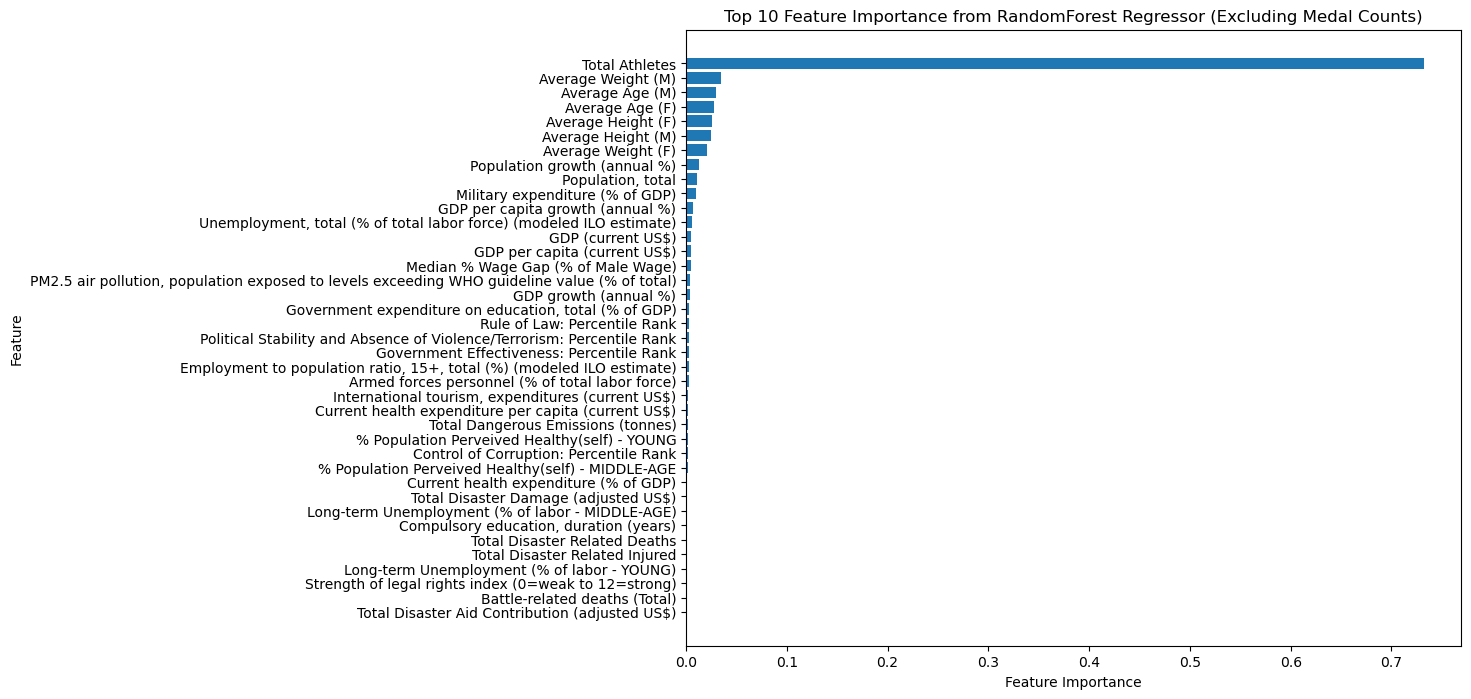

In [63]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance from RandomForest Regressor (Excluding Medal Counts)')
plt.gca().invert_yaxis()
plt.show()

In [64]:
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
nn_model.compile(optimizer='adam', loss='mean_absolute_error')

In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [67]:
history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2322 - val_loss: 3.5469
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8102 - val_loss: 3.2793
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3527 - val_loss: 2.8592
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9997 - val_loss: 2.5371
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3659 - val_loss: 2.4079
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6052 - val_loss: 2.2596
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2209 - val_loss: 2.2012
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4610 - val_loss: 2.1831
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3138 - val_loss: 2.1639
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2949 - val_loss: 2.1578
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2126 - val_loss: 2.1598
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1

In [68]:
test_loss = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network - MAE on Test Data: {test_loss:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0005
Neural Network - MAE on Test Data: 2.61


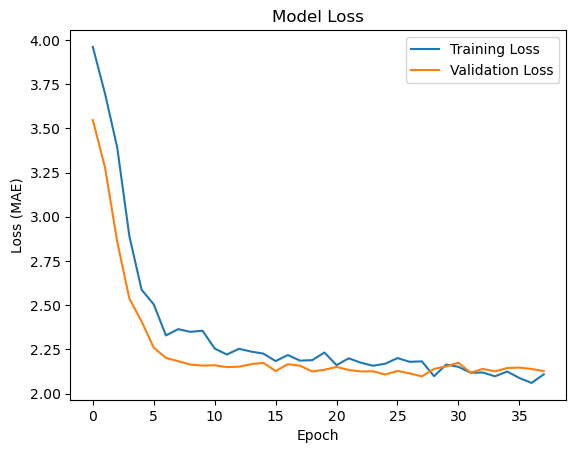

In [69]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


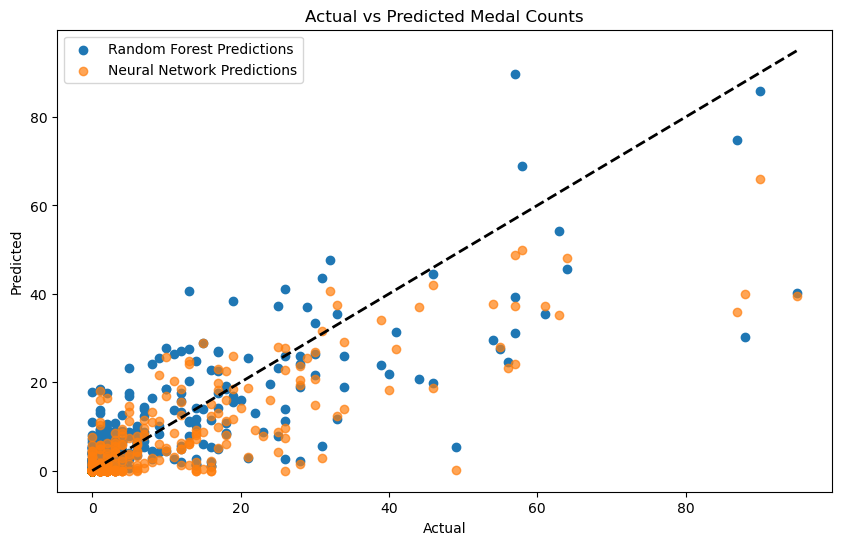

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, label='Random Forest Predictions')
plt.scatter(y_test, nn_model.predict(X_test_scaled), label='Neural Network Predictions', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Medal Counts')
plt.legend()
plt.show()

In [54]:
# Save the model to an HDF5 file
nn_model.save('Initial_Model.h5')